In [1]:
# Get all the required imports
import pandas as pd
import matplotlib.pyplot as plt
import glob
import plotly.graph_objs as go
import ipywidgets as w
from IPython.display import display

In [2]:
# Standard plotly imports
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode, plot
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
#init_notebook_mode(connected=True)

import plotly.express as px
import chart_studio

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%config IPCompleter.greedy=True

In [5]:
# Read the list of nifty 50 stocks into a dataframe
df_nifty50 = pd.read_csv('ind_nifty50list.csv')

# Get the nifty50 synbols into a python list
nifty50_symbols = list(df_nifty50['Symbol'])

In [6]:
# Loop through all the excel files and load only nifty50 stocks
# We see that we don't have data files for all the nifty50 stocks. We only have data for 44 stocks
df_stock_data = pd.DataFrame()
for file in glob.glob('HISTORICAL_DATA\HISTORICAL_DATA\*.csv'):
    file_name = file.split('\\')[-1].split('_')[0]
    if file_name in nifty50_symbols:
        df_temp = pd.read_csv(file)
        df_temp['stock_symbol'] = file_name
        df_stock_data = df_stock_data.append(df_temp)

In [7]:
# Calculate some basic stats about each stock
# Getting the minimun, maximum and mean values of each stock over the entire time period
stock_stats = df_stock_data.groupby(['stock_symbol'])['close'].agg(['min','max','mean'])

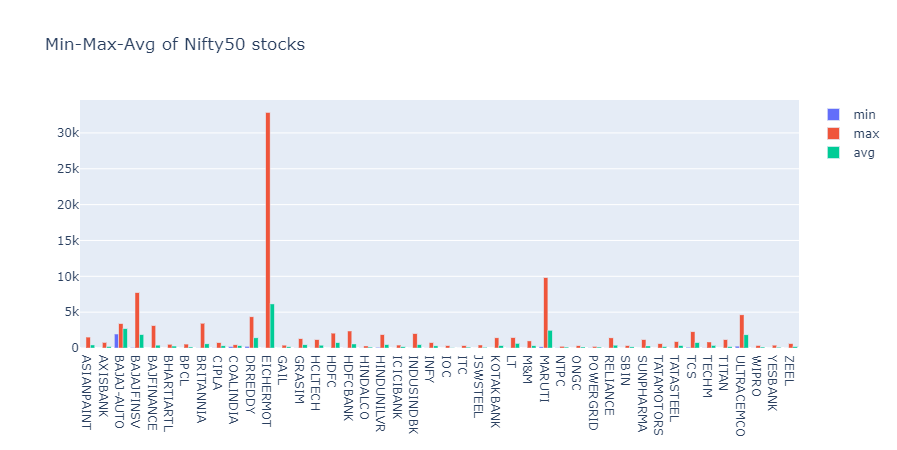

In [8]:
# Plot the above stats in plotly
stocks = stock_stats.index
fig = go.Figure(data = [
                            go.Bar(name='min', x=stocks, y=stock_stats['min']),
                            go.Bar(name='max', x=stocks, y=stock_stats['max']),
                            go.Bar(name='avg', x=stocks, y=stock_stats['mean'])
                        ],
                layout_title_text = 'Min-Max-Avg of Nifty50 stocks'
               )
fig.update_layout(barmode='group')
fig.show()

In [9]:
# Calculate the moving average of each stock
# Create a column for moving average 50 and moving average 10
df_stock_data['MA50'] = df_stock_data.groupby(['stock_symbol'])['close'].transform(lambda x: x.rolling(50,1).mean())
df_stock_data['MA10'] = df_stock_data.groupby(['stock_symbol'])['close'].transform(lambda x: x.rolling(10,1).mean())

In [10]:
df_stock_data[df_stock_data['stock_symbol']=='ITC'].tail()

,Date,open,high,low,close,adj_close,volume,stock_symbol,MA50,MA10
4849,2019-05-09,299.399994,301.299988,296.350006,299.850006,299.850006,10223616.0,ITC,294.428998,303.514999
4850,2019-05-10,300.000000,300.450012,296.899994,297.750000,297.750000,6904657.0,ITC,294.866998,302.644998
4851,2019-05-13,295.100006,303.500000,287.700012,289.299988,289.299988,35880558.0,ITC,295.151998,301.159998
4852,2019-05-14,291.000000,298.250000,288.850006,294.350006,294.350006,21145225.0,ITC,295.552999,300.139999
4853,2019-05-15,297.549988,297.950012,292.000000,297.100006,297.100006,7694095.0,ITC,295.960999,299.714999


In [11]:
# Add the 'Shares' columns which tell when you are holding the stock and when you are not
# As long as the MA10 > MA50 we hold the stock and Shares column say 1.
# If MA10 < MA50, we don't hold the stock and the column says 0

df_stock_data['Shares'] = df_stock_data.apply(lambda x: 1 if x['MA10']>x['MA50'] else 0, axis=1)

# Get the next day closing price to calcculate the profit
df_stock_data['Close_next_day'] = df_stock_data.groupby(['stock_symbol'])['close'].shift(-1)

# Profit is calculated for only those days we hold the stock. It is the difference between today and tomorrow close price
df_stock_data['Profit'] = df_stock_data.apply(lambda x: x['Close_next_day'] - x['close'] if x['Shares']==1 else 0, axis=1)

In [12]:
# Create a plotly graph to show Profit on each day, closing price, MA50 and MA10
# You can use the filter the data to different stocks. Default is ALL selection
dates = df_stock_data.Date
fig = go.FigureWidget(data = [
                            go.Line(name='Profit', x=dates, y=df_stock_data['Profit']),
                            go.Line(name='close', x=dates, y=df_stock_data['close']),
                            go.Line(name='MA50', x=dates, y=df_stock_data['MA50']),
                            go.Line(name='MA10', x=dates, y=df_stock_data['MA10'])
                        ],
                layout_title_text = 'Profit-Close-MA50-MA10 of Nifty50 stocks'
               )
fig.update_layout(xaxis = dict(rangeslider=dict(
            visible = True)
        ))

def update_fig(change):
    if dropdown.value == 'ALL':
        aux_df =  df_stock_data
    else:
        aux_df = df_stock_data[df_stock_data.stock_symbol.isin([dropdown.value])]
    with fig.batch_update():
        for trace, column in zip(fig.data, ['Profit', 'close', 'MA50', 'MA10']):
            trace.x = aux_df['Date']
            trace.y = aux_df[column]
            
dropdown = w.Dropdown(description='Stock Symbol: ',options=['ALL']+df_stock_data.stock_symbol.unique().tolist(),value='ALL')
dropdown.observe(update_fig, names='value')
display(w.VBox([dropdown, fig]))


In [13]:
# Calculate the cumulative wealth aquired on each stock by summing up each days profit

df_stock_data['wealth'] = df_stock_data.groupby(['stock_symbol'])['Profit'].cumsum()

In [14]:
# Ploting the cummulative profit of the stock over time period.
# The red line serves as the 0 reference line
dates = df_stock_data.Date
fig = go.FigureWidget(data = [
                            go.Line(name='Wealth', x=dates, y=df_stock_data['wealth']),
                            go.Scatter(name='Zero-Line',x=dates,y=[0] * len(dates), mode='lines')
                        ],
                layout_title_text = 'Accumulated wealth of Nifty50 stocks'
               )
fig.update_layout(xaxis = dict(rangeslider=dict(
            visible = True)
        ))

def update_fig(change):
    if dropdown.value == 'ALL':
        aux_df =  df_stock_data
    else:
        aux_df = df_stock_data[df_stock_data.stock_symbol.isin([dropdown.value])]
    with fig.batch_update():
        for trace, column in zip(fig.data, ['wealth','reference']):
            trace.x = aux_df['Date']
            trace.y = aux_df[column]
            
dropdown = w.Dropdown(description='Stock Symbol: ',options=['ALL']+df_stock_data.stock_symbol.unique().tolist(),value='ALL')
dropdown.observe(update_fig, names='value')
display(w.VBox([dropdown, fig]))